In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import sqlite3
import stats
from sklearn.cluster import KMeans

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

%load_ext sql
%config InlineBackend.figure_formats = ['svg']

This was an assessment a company asked me to do. They sent me a dataset that contains activities on twitter to answer several questions.

# Importing data

In [2]:
df = pd.read_csv('Analyst Assessment.csv')
df.head()

,Outbound Post,Status,Account Type,Account,Published Date,Events (Outbound Message),Campaign,Message Type,Content Type (Outbound Message),Media Format,Total Engagements (SUM),Post Likes And Reactions (SUM),Post Shares (SUM),Post Comments (SUM),Twitter URL Clicks (SUM),Twitter Video Views (SUM),Twitter Media Clicks (SUM),Twitter Hashtag Clicks (SUM),Twitter Profile Clicks (SUM),Twitter Detail Expands (SUM),Twitter User Follows (SUM),Overall Post Impressions
0,Post 1,SENT,TWITTER,Account 1,01-03-2017 11:31,NaN,N/A | N/A,Update,Case Study,Image,26,14,12,0,0,0,0,0,0,0,0,8013
1,Post 2,SENT,TWITTER,Account 3,01-03-2017 12:00,NaN,N/A | N/A,Update,Learning Courses / Labs,Text,78,42,35,1,0,0,0,0,0,0,0,12818
2,Post 3,SENT,TWITTER,Account 1,01-04-2017 09:00,NaN,N/A | N/A,Update,User Support Content,Photo,23,11,12,0,0,0,0,0,0,0,0,7145
3,Post 4,SENT,TWITTER,Account 2,01-04-2017 11:30,NaN,N/A | N/A,Update,Press Coverage,Text,20,13,7,0,0,0,0,0,0,0,0,2528
4,Post 5,SENT,TWITTER,Account 3,01-04-2017 11:44,NaN,N/A | N/A,Update,Blog,Text,54,35,19,0,0,0,0,0,0,0,0,7957


In [3]:
df.shape

(2073, 22)

# Exploring data

In [4]:
df.groupby(['Account']).size().to_frame('count')

,count
Account,
Account 1,664
Account 2,631
Account 3,778


There are 3 accounts in this dataset

In [5]:
df.groupby(['Media Format']).size().to_frame('count').sort_values('count', ascending=False)

,count
Media Format,
Image,1181
Text,801
Photo,48
Live Video,17
Video,17
GIF,8
Link,1


There are different formats of posts. Image is the most popular format, followed by text.

In [6]:
df.groupby(['Content Type (Outbound Message)']).size().to_frame('count').sort_values('count', ascending=False)

,count
Content Type (Outbound Message),
Blog,389
Landing Page,304
Webinar,238
Video,186
eBook,143
Whitepaper,97
Reports,96
Article,95
Customer Story,91


There are many different content types, with blog being most common, followed by landing page.

Next, I looked at the questions, and these were the columns of particular interest in this assessment.

In [7]:
df[['Total Engagements (SUM)','Twitter URL Clicks (SUM)', 'Twitter Video Views (SUM)', 'Twitter Media Clicks (SUM)', 'Overall Post Impressions']].describe()

,Total Engagements (SUM),Twitter URL Clicks (SUM),Twitter Video Views (SUM),Twitter Media Clicks (SUM),Overall Post Impressions
count,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000
mean,22.359865,14.885191,9.528702,4.845152,5472.228172
std,27.930308,35.014205,114.745750,19.958636,5413.895278
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,4.000000,0.000000,0.000000,2317.000000
50%,15.000000,9.000000,0.000000,1.000000,4595.000000
75%,27.000000,17.000000,0.000000,4.000000,6671.000000
max,669.000000,1281.000000,3475.000000,712.000000,90930.000000


Because the first few questions were about posts made in April, I began the assessment by dividing the data by month.

# Divide the data by month

In [8]:
df['date'] = pd.to_datetime(df['Published Date'])
df['month'] = df['date'].apply(lambda x: x.month)
df['month_name'] = df['date'].apply(lambda x: x.month_name())
df.head()

,Outbound Post,Status,Account Type,Account,Published Date,Events (Outbound Message),Campaign,Message Type,Content Type (Outbound Message),Media Format,Total Engagements (SUM),Post Likes And Reactions (SUM),Post Shares (SUM),Post Comments (SUM),Twitter URL Clicks (SUM),Twitter Video Views (SUM),Twitter Media Clicks (SUM),Twitter Hashtag Clicks (SUM),Twitter Profile Clicks (SUM),Twitter Detail Expands (SUM),Twitter User Follows (SUM),Overall Post Impressions,date,month,month_name
0,Post 1,SENT,TWITTER,Account 1,01-03-2017 11:31,NaN,N/A | N/A,Update,Case Study,Image,26,14,12,0,0,0,0,0,0,0,0,8013,2017-01-03 11:31:00,1,January
1,Post 2,SENT,TWITTER,Account 3,01-03-2017 12:00,NaN,N/A | N/A,Update,Learning Courses / Labs,Text,78,42,35,1,0,0,0,0,0,0,0,12818,2017-01-03 12:00:00,1,January
2,Post 3,SENT,TWITTER,Account 1,01-04-2017 09:00,NaN,N/A | N/A,Update,User Support Content,Photo,23,11,12,0,0,0,0,0,0,0,0,7145,2017-01-04 09:00:00,1,January
3,Post 4,SENT,TWITTER,Account 2,01-04-2017 11:30,NaN,N/A | N/A,Update,Press Coverage,Text,20,13,7,0,0,0,0,0,0,0,0,2528,2017-01-04 11:30:00,1,January
4,Post 5,SENT,TWITTER,Account 3,01-04-2017 11:44,NaN,N/A | N/A,Update,Blog,Text,54,35,19,0,0,0,0,0,0,0,0,7957,2017-01-04 11:44:00,1,January


In [9]:
april = df[df['month_name'] == 'April']
april.head()

,Outbound Post,Status,Account Type,Account,Published Date,Events (Outbound Message),Campaign,Message Type,Content Type (Outbound Message),Media Format,Total Engagements (SUM),Post Likes And Reactions (SUM),Post Shares (SUM),Post Comments (SUM),Twitter URL Clicks (SUM),Twitter Video Views (SUM),Twitter Media Clicks (SUM),Twitter Hashtag Clicks (SUM),Twitter Profile Clicks (SUM),Twitter Detail Expands (SUM),Twitter User Follows (SUM),Overall Post Impressions,date,month,month_name
451,Post 452,SENT,TWITTER,Account 1,04-03-2017 12:35,NaN,N/A | N/A,Update,Downloads,Image,35,16,19,0,19,0,4,0,0,9,0,5968,2017-04-03 12:35:00,4,April
452,Post 453,SENT,TWITTER,Account 3,04-03-2017 13:30,NaN,Campaign 3,Update,Landing Page,Image,16,8,8,0,7,0,1,0,4,15,0,5744,2017-04-03 13:30:00,4,April
453,Post 454,SENT,TWITTER,Account 2,04-03-2017 14:00,NaN,N/A | N/A,Update,Blog,Image,3,3,0,0,11,0,0,0,0,0,0,1135,2017-04-03 14:00:00,4,April
454,Post 455,SENT,TWITTER,Account 3,04-04-2017 13:55,Event 1,N/A | N/A,Update,Landing Page,Image,45,24,20,1,31,0,12,7,5,11,-1,6612,2017-04-04 13:55:00,4,April
455,Post 456,SENT,TWITTER,Account 2,04-04-2017 14:10,Event 1,N/A | N/A,Update,Landing Page,Image,16,9,7,0,8,0,1,1,0,7,0,1890,2017-04-04 14:10:00,4,April


Now I have a dataframe that only contains data from April

# Q1. Which account amplified the most posts in April?

In [10]:
april.groupby(['Account']).size().to_frame('count')

,count
Account,
Account 1,53
Account 2,78
Account 3,105


Account 3 is the one that amplified the most posts

### Q1. What was the # of URL clicks, total engagements, and total impressions for this account?

In [11]:
sdf = df.groupby(['month', 'month_name', 'Account']).sum()
sdf.head(15)

Total Engagements (SUM)  \
month month_name Account                              
1     January    Account 1                     1386   
                 Account 2                      306   
                 Account 3                     2205   
2     February   Account 1                      962   
                 Account 2                      428   
                 Account 3                     1993   
3     March      Account 1                     1216   
                 Account 2                      816   
                 Account 3                     2629   
4     April      Account 1                     1055   
                 Account 2                     1163   
                 Account 3                     3459   
5     May        Account 1                     1348   
                 Account 2                      828   
                 Account 3                     2784   

                            Post Likes And Reactions (SUM)  Post Shares (SUM)  \
month month_name Account                                                        
1     January    Account 1                             610                769   
                 Account 2                             184                122   
                 Account 3                            1251                925   
2     February   Account 1                             452                505   
                 Account 2                             227                201   
                 Account 3                            1167                800   
3     March      Account 1                             601                607   
                 Account 2                             405                411   
                 Account 3                            1425               1182   
4     April      Account 1                             494                560   
                 Account 2                             655                503   
                 Account 3                            1841               1600   
5     May        Account 1                             656                686   
                 Account 2                             461                358   
                 Account 3                            1606               1156   

                            Post Comments (SUM)  Twitter URL Clicks (SUM)  \
month month_name Account                                                    
1     January    Account 1                    7                       616   
                 Account 2                    0                        51   
                 Account 3                   29                       576   
2     February   Account 1                    5                       700   
                 Account 2                    0                       372   
                 Account 3                   26                      1658   
3     March      Account 1                    8                       831   
                 Account 2                    0                       578   
                 Account 3                   22                      2157   
4     April      Account 1                    1                       761   
                 Account 2                    5                       536   
                 Account 3                   18                      3873   
5     May        Account 1                    6                      1121   
                 Account 2                    9                       416   
                 Account 3                   22                      2217   

                            Twitter Video Views (SUM)  \
month month_name Account                                
1     January    Account 1                          0   
                 Account 2                          0   
                 Account 3                        606   
2     February   Account 1                          0   
                 Account 2                          0   
     

In April, Account 3 generated 3,873 URL clicks, 3,459 total engagements, and 761,984 impressions.

# Q.2 What are the top 3 content types among these posts?

In [12]:
april_account3 = april[april.Account == 'Account 3']
april_account3.groupby(['Content Type (Outbound Message)']).size().to_frame('count').sort_values('count', ascending=False)

,count
Content Type (Outbound Message),
Blog,33
Landing Page,33
Webinar,8
Reports,6
Solution,4
Whitepaper,4
eBook,4
Product,3
Community Forums,2


Blog and landing page are as common, followed by webinar

# Q2. Which post number drove the highest URL clicks?

In [13]:
april_account3['Twitter URL Clicks (SUM)'].max()

1281

In [14]:
april_account3[april_account3['Twitter URL Clicks (SUM)'] == 1281]

,Outbound Post,Status,Account Type,Account,Published Date,Events (Outbound Message),Campaign,Message Type,Content Type (Outbound Message),Media Format,Total Engagements (SUM),Post Likes And Reactions (SUM),Post Shares (SUM),Post Comments (SUM),Twitter URL Clicks (SUM),Twitter Video Views (SUM),Twitter Media Clicks (SUM),Twitter Hashtag Clicks (SUM),Twitter Profile Clicks (SUM),Twitter Detail Expands (SUM),Twitter User Follows (SUM),Overall Post Impressions,date,month,month_name
582,Post 583,SENT,TWITTER,Account 3,04-19-2017 08:42,Event 1,N/A | N/A,Update,Blog,Image,232,124,105,3,1281,0,712,120,107,779,8,40940,2017-04-19 08:42:00,4,April


Post 583 drove 1,281 URL clicks.

# Question 3: On average, posts with which Media Format performed the highest in August?

In [15]:
august = df[df['month_name'] == 'August'].copy()
august = august.groupby(['Media Format']).agg({
  'Outbound Post': 'count',
  'Total Engagements (SUM)': 'sum',
  'Twitter URL Clicks (SUM)': 'sum',
  'Overall Post Impressions': 'sum'
})
august.head()

,Outbound Post,Total Engagements (SUM),Twitter URL Clicks (SUM),Overall Post Impressions
Media Format,,,,
GIF,2,49,3,18295
Image,162,2952,1650,795028
Photo,4,36,14,14351
Text,123,2052,1075,441496


In August, image drove the highest numbers of total engagements, URL clicks, and overall impressions across 3 accounts.

# Month-over-month charts showcasing the number of posts published and the amount of URL Clicks driven by each account. 

For this question, I generated a table that can show the number of posts and URL clicks across months for all 3 acounts.

In [16]:
cdf = df.groupby(['month', 'month_name', 'Account']).size().to_frame('posts')
cdf.head()

posts
month month_name Account         
1     January    Account 1     49
                 Account 2     25
                 Account 3     51
2     February   Account 1     41
                 Account 2     37

In [17]:
adf = sdf.join(cdf)
adf.head()

Total Engagements (SUM)  \
month month_name Account                              
1     January    Account 1                     1386   
                 Account 2                      306   
                 Account 3                     2205   
2     February   Account 1                      962   
                 Account 2                      428   

                            Post Likes And Reactions (SUM)  Post Shares (SUM)  \
month month_name Account                                                        
1     January    Account 1                             610                769   
                 Account 2                             184                122   
                 Account 3                            1251                925   
2     February   Account 1                             452                505   
                 Account 2                             227                201   

                            Post Comments (SUM)  Twitter URL Clicks (SUM)  \
month month_name Account                                                    
1     January    Account 1                    7                       616   
                 Account 2                    0                        51   
                 Account 3                   29                       576   
2     February   Account 1                    5                       700   
                 Account 2                    0                       372   

                            Twitter Video Views (SUM)  \
month month_name Account                                
1     January    Account 1                          0   
                 Account 2                          0   
                 Account 3                        606   
2     February   Account 1                          0   
                 Account 2                          0   

                            Twitter Media Clicks (SUM)  \
month month_name Account                                 
1     January    Account 1                          88   
                 Account 2                           6   
                 Account 3                         269   
2     February   Account 1                         165   
                 Account 2                          51   

                            Twitter Hashtag Clicks (SUM)  \
month month_name Account                                   
1     January    Account 1                            71   
                 Account 2                             2   
                 Account 3                            44   
2     February   Account 1                            38   
                 Account 2                            24   

                            Twitter Profile Clicks (SUM)  \
month month_name Account                                   
1     January    Account 1                            54   
                 Account 2                             8   
                 Account 3                            83   
2     February   Account 1                            73   
                 Account 2                            37   

                            Twitter Detail Expands (SUM)  \
month month_name Account                                   
1     January    Account 1                           398   
                 Account 2                            10   
                 Account 3                           293   
2     February   Account 1                           782   
                 Account 2                            84   

                            Twitter User Follows (SUM)  \
month month_name Account                                 
1     January    Account 1                          -1   
                 Account 2                           0   
                 Account 3                          -6   
2     February   Account 1                          -4   
                 Account 2                           0   

                            Overall Post Impressions  pos

In [18]:
radf = adf.reset_index()
radf.head()

,month,month_name,Account,Total Engagements (SUM),Post Likes And Reactions (SUM),Post Shares (SUM),Post Comments (SUM),Twitter URL Clicks (SUM),Twitter Video Views (SUM),Twitter Media Clicks (SUM),Twitter Hashtag Clicks (SUM),Twitter Profile Clicks (SUM),Twitter Detail Expands (SUM),Twitter User Follows (SUM),Overall Post Impressions,posts
0,1,January,Account 1,1386,610,769,7,616,0,88,71,54,398,-1,355436,49
1,1,January,Account 2,306,184,122,0,51,0,6,2,8,10,0,55674,25
2,1,January,Account 3,2205,1251,925,29,576,606,269,44,83,293,-6,462632,51
3,2,February,Account 1,962,452,505,5,700,0,165,38,73,782,-4,351220,41
4,2,February,Account 2,428,227,201,0,372,0,51,24,37,84,0,86799,37


Now I have the dataframe ready. Below, I created charts one by one.

A chart for the # of posts generated by Account 1

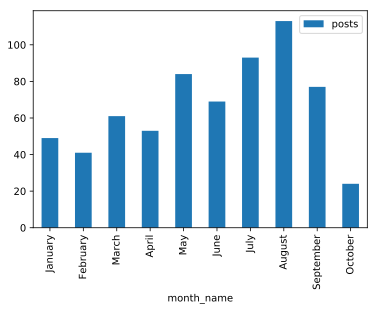

In [19]:
radf[radf['Account'] == 'Account 1'].plot.bar(x='month_name', y=['posts'])

A chart for the # of URL clicks driven by Account 1

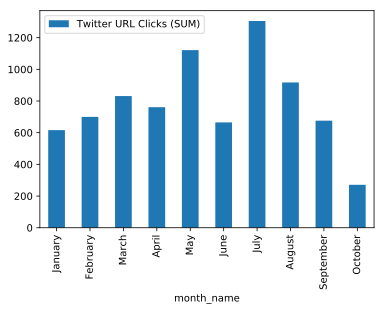

In [20]:
radf[radf['Account'] == 'Account 1'].plot.bar(x='month_name', y=['Twitter URL Clicks (SUM)'])

A chart for the # of posts generated by Account 2

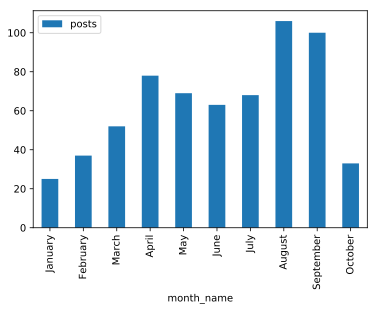

In [21]:
radf[radf['Account'] == 'Account 2'].plot.bar(x='month_name', y=['posts'])

A chart for the # of URL clicks driven by Account 2

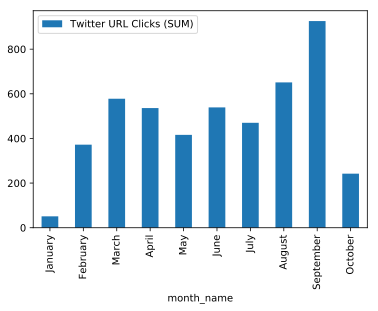

In [22]:
radf[radf['Account'] == 'Account 2'].plot.bar(x='month_name', y=['Twitter URL Clicks (SUM)'])

A chart for the # of posts generated by Account 3

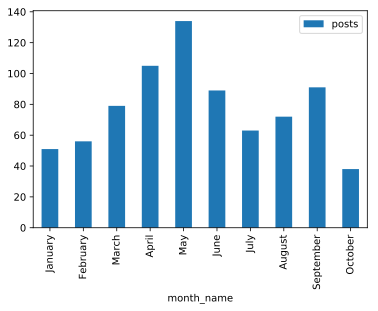

In [23]:
radf[radf['Account'] == 'Account 3'].plot.bar(x='month_name', y=['posts'])

A chart for the # of URL clicks driven by Account 3

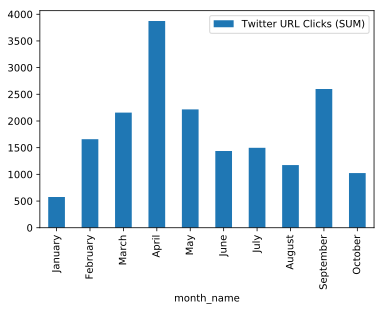

In [24]:
radf[radf['Account'] == 'Account 3'].plot.bar(x='month_name', y=['Twitter URL Clicks (SUM)'])